# Multivariate Time-Series Anomaly Detection for Equipment Sensors

## Objective
This project aims to detect anomalies in multivariate equipment sensor data using:
- Isolation Forest (machine learning)
- LSTM Autoencoder (deep learning)

The goal is to identify abnormal sensor behavior that may indicate faults or failures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv("data/Rotating_equipment_fault_data.csv")

In [3]:
data.head()

,Timestamp,Vibration_X,Vibration_Y,Vibration_Z,Acoustic_Level,Temperature,Fault_Type
0,2024-01-17 01:00:00,0.437354,0.573451,0.610491,46.354242,62.981501,Imbalance
1,2024-01-13 01:22:00,0.508706,0.563557,0.501379,42.746082,64.987678,Imbalance
2,2024-01-07 05:53:00,0.790265,0.982779,0.557218,67.908620,76.911262,Bearing Fault
3,2024-01-14 14:06:00,0.483201,0.629288,0.427317,44.590852,65.219862,Imbalance
4,2024-01-03 15:18:00,0.150332,0.286465,0.233508,28.409900,56.432483,Normal


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Timestamp       32000 non-null  object 
 1   Vibration_X     32000 non-null  float64
 2   Vibration_Y     32000 non-null  float64
 3   Vibration_Z     32000 non-null  float64
 4   Acoustic_Level  32000 non-null  float64
 5   Temperature     32000 non-null  float64
 6   Fault_Type      32000 non-null  object 
dtypes: float64(5), object(2)
memory usage: 1.7+ MB


In [5]:
data.describe()

,Vibration_X,Vibration_Y,Vibration_Z,Acoustic_Level,Temperature
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,0.450043,0.480370,0.420065,46.269830,72.500640
std,0.239994,0.257872,0.222880,17.116510,11.925126
min,0.015582,0.003880,0.007181,12.232175,51.068792
25%,0.250425,0.260302,0.240060,32.252273,62.234071
50%,0.382255,0.417618,0.349887,42.114629,69.558693
75%,0.623908,0.671748,0.572550,58.265032,80.781314
max,1.153653,1.224538,1.099511,105.360481,109.884341


In [6]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       32000 non-null  datetime64[ns]
 1   Vibration_X     32000 non-null  float64       
 2   Vibration_Y     32000 non-null  float64       
 3   Vibration_Z     32000 non-null  float64       
 4   Acoustic_Level  32000 non-null  float64       
 5   Temperature     32000 non-null  float64       
 6   Fault_Type      32000 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 1.7+ MB


In [8]:
data = data.sort_values('Timestamp')
data = data.reset_index(drop=True)

In [9]:
labels = data['Fault_Type']
features = data.drop(columns=['Fault_Type'])

In [10]:
features.head()
labels.value_counts()

Fault_Type
Normal           8000
Bearing Fault    8000
Imbalance        8000
Overheating      8000
Name: count, dtype: int64

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [12]:
dict(zip(le.classes_, le.transform(le.classes_)))

{'Bearing Fault': np.int64(0),
 'Imbalance': np.int64(1),
 'Normal': np.int64(2),
 'Overheating': np.int64(3)}

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

sensor_columns = ['Vibration_X', 'Vibration_Y', 'Vibration_Z',
                  'Acoustic_Level', 'Temperature']

features[sensor_columns] = scaler.fit_transform(features[sensor_columns])

In [14]:
features.describe()

,Timestamp,Vibration_X,Vibration_Y,Vibration_Z,Acoustic_Level,Temperature
count,32000,3.200000e+04,3.200000e+04,3.200000e+04,3.200000e+04,3.200000e+04
mean,2024-01-12 02:39:30,1.847411e-16,-2.273737e-16,-7.105427e-17,8.526513e-17,-1.477929e-15
min,2024-01-01 00:00:00,-1.810330e+00,-1.847807e+00,-1.852524e+00,-1.988617e+00,-1.797229e+00
25%,2024-01-06 13:19:45,-8.317753e-01,-8.534150e-01,-8.076467e-01,-8.189623e-01,-8.609326e-01
50%,2024-01-12 02:39:30,-2.824604e-01,-2.433484e-01,-3.148737e-01,-2.427636e-01,-2.467054e-01
75%,2024-01-17 15:59:15,7.244691e-01,7.421566e-01,6.841684e-01,7.008081e-01,6.943997e-01
max,2024-01-23 05:19:00,2.931830e+00,2.885850e+00,3.048538e+00,3.452314e+00,3.134917e+00
std,NaN,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00


In [15]:
features.head()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       32000 non-null  datetime64[ns]
 1   Vibration_X     32000 non-null  float64       
 2   Vibration_Y     32000 non-null  float64       
 3   Vibration_Z     32000 non-null  float64       
 4   Acoustic_Level  32000 non-null  float64       
 5   Temperature     32000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.5 MB


In [16]:
labels.value_counts()

Fault_Type
Normal           8000
Bearing Fault    8000
Imbalance        8000
Overheating      8000
Name: count, dtype: int64

In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       32000 non-null  datetime64[ns]
 1   Vibration_X     32000 non-null  float64       
 2   Vibration_Y     32000 non-null  float64       
 3   Vibration_Z     32000 non-null  float64       
 4   Acoustic_Level  32000 non-null  float64       
 5   Temperature     32000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.5 MB


In [18]:
features.head()

,Timestamp,Vibration_X,Vibration_Y,Vibration_Z,Acoustic_Level,Temperature
0,2024-01-01 00:00:00,-0.938402,-1.093666,-0.790122,-1.146671,-0.925507
1,2024-01-01 00:01:00,-1.070695,-1.184919,-0.978567,-1.159064,-1.318562
2,2024-01-01 00:02:00,-0.906948,-1.120686,-1.192056,-0.534159,-1.161711
3,2024-01-01 00:03:00,-0.724578,-0.948678,-1.091143,-0.405916,-1.277720
4,2024-01-01 00:04:00,-1.090673,-0.839489,-0.910470,-1.221894,-1.016528


## Feature Extraction using tsfresh
In this section, time-series sensor data is segmented into fixed windows and statistical features are extracted using tsfresh.

In [19]:
WINDOW_SIZE = 50
features['window_id'] = features.index // WINDOW_SIZE

In [20]:
features[['Timestamp', 'window_id']].head(60)

,Timestamp,window_id
0,2024-01-01 00:00:00,0
1,2024-01-01 00:01:00,0
2,2024-01-01 00:02:00,0
3,2024-01-01 00:03:00,0
4,2024-01-01 00:04:00,0
5,2024-01-01 00:05:00,0
6,2024-01-01 00:06:00,0
7,2024-01-01 00:07:00,0
8,2024-01-01 00:08:00,0
9,2024-01-01 00:09:00,0


In [21]:
long_df = features.melt(
    id_vars=['window_id', 'Timestamp'],
    value_vars=[
        'Vibration_X',
        'Vibration_Y',
        'Vibration_Z',
        'Acoustic_Level',
        'Temperature'
    ],
    var_name='sensor',
    value_name='value'
)

In [22]:
long_df.head()

,window_id,Timestamp,sensor,value
0,0,2024-01-01 00:00:00,Vibration_X,-0.938402
1,0,2024-01-01 00:01:00,Vibration_X,-1.070695
2,0,2024-01-01 00:02:00,Vibration_X,-0.906948
3,0,2024-01-01 00:03:00,Vibration_X,-0.724578
4,0,2024-01-01 00:04:00,Vibration_X,-1.090673


In [23]:
from tsfresh import extract_features
print("tsfresh imported successfully")

tsfresh imported successfully


In [24]:
long_df = features.melt(
    id_vars=['window_id', 'Timestamp'],
    value_vars=[
        'Vibration_X',
        'Vibration_Y',
        'Vibration_Z',
        'Acoustic_Level',
        'Temperature'
    ],
    var_name='sensor',
    value_name='value'
)

In [25]:
long_df.head()

,window_id,Timestamp,sensor,value
0,0,2024-01-01 00:00:00,Vibration_X,-0.938402
1,0,2024-01-01 00:01:00,Vibration_X,-1.070695
2,0,2024-01-01 00:02:00,Vibration_X,-0.906948
3,0,2024-01-01 00:03:00,Vibration_X,-0.724578
4,0,2024-01-01 00:04:00,Vibration_X,-1.090673


In [26]:
from tsfresh import extract_features

extracted_features = extract_features(
    long_df,
    column_id='window_id',
    column_sort='Timestamp',
    column_kind='sensor',
    column_value='value'
)

Feature Extraction: 100%|██████████████████| 30/30 [00:58<00:00,  1.94s/it]


In [27]:
extracted_features.shape

(640, 3915)

In [28]:
extracted_features.head()

,Vibration_X__variance_larger_than_standard_deviation,Vibration_X__has_duplicate_max,Vibration_X__has_duplicate_min,Vibration_X__has_duplicate,Vibration_X__sum_values,Vibration_X__abs_energy,Vibration_X__mean_abs_change,Vibration_X__mean_change,Vibration_X__mean_second_derivative_central,Vibration_X__median,...,Temperature__fourier_entropy__bins_5,Temperature__fourier_entropy__bins_10,Temperature__fourier_entropy__bins_100,Temperature__permutation_entropy__dimension_3__tau_1,Temperature__permutation_entropy__dimension_4__tau_1,Temperature__permutation_entropy__dimension_5__tau_1,Temperature__permutation_entropy__dimension_6__tau_1,Temperature__permutation_entropy__dimension_7__tau_1,Temperature__query_similarity_count__query_None__threshold_0.0,Temperature__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,0.0,-54.443226,61.135406,0.225712,-0.009608,-0.003194,-1.090671,...,1.346200,1.964329,2.951252,1.742933,2.915371,3.636445,3.806662,3.784190,NaN,1.352676
1,0.0,0.0,0.0,0.0,-51.909218,55.517243,0.209001,-0.002375,0.001019,-1.032288,...,1.125336,1.725603,2.971377,1.754600,2.984023,3.606309,3.745049,3.784190,NaN,1.331126
2,0.0,0.0,0.0,0.0,-52.503705,57.325765,0.265318,0.007281,-0.002647,-1.038377,...,1.365439,1.925121,2.938182,1.786537,2.972890,3.617684,3.775856,3.784190,NaN,1.316379
3,0.0,0.0,0.0,0.0,-51.220483,54.169570,0.215420,-0.005925,-0.002815,-1.001546,...,1.399789,1.908347,2.971377,1.771603,2.881972,3.546035,3.683436,3.752683,NaN,1.390414
4,0.0,0.0,0.0,0.0,-50.521781,53.584989,0.257934,0.000201,-0.003393,-0.999917,...,0.852865,1.245043,2.791295,1.778620,2.931880,3.647820,3.775856,3.784190,NaN,1.299083


In [29]:
extracted_features = extracted_features.fillna(0)

In [30]:
import numpy as np

extracted_features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [31]:
extracted_features.fillna(0, inplace=True)

In [32]:
np.isinf(extracted_features.values).sum(), extracted_features.isna().sum().sum()

(np.int64(0), np.int64(0))

In [33]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
X_features = feature_scaler.fit_transform(extracted_features)

In [34]:
X_features.shape

(640, 3915)

## Anomaly Detection using Isolation Forest
In this section, an Isolation Forest model is used to detect anomalies based on extracted time-series features.

In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.25,
    random_state=42
)

iso_forest.fit(X_features)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",200
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.25
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [37]:
iso_predictions = iso_forest.predict(X_features)

In [38]:
iso_anomaly_labels = (iso_predictions == -1).astype(int)

In [39]:
import numpy as np
np.unique(iso_anomaly_labels, return_counts=True)

(array([0, 1]), array([480, 160]))

In [40]:
window_labels = labels.groupby(features['window_id']).first()
window_labels = window_labels.iloc[:len(extracted_features)]

In [41]:
print(window_labels.head())
print(type(window_labels))

window_id
0    Normal
1    Normal
2    Normal
3    Normal
4    Normal
Name: Fault_Type, dtype: object
<class 'pandas.core.series.Series'>


In [42]:
true_anomaly_labels = (window_labels != 'Normal').astype(int)

In [43]:
np.unique(true_anomaly_labels, return_counts=True)

(array([0, 1]), array([160, 480]))

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_anomaly_labels, iso_anomaly_labels))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50       160
           1       1.00      0.33      0.50       480

    accuracy                           0.50       640
   macro avg       0.67      0.67      0.50       640
weighted avg       0.83      0.50      0.50       640



In [45]:
confusion_matrix(true_anomaly_labels, iso_anomaly_labels)

array([[160,   0],
       [320, 160]])

### Isolation Forest Evaluation
The Isolation Forest model detects anomalies based on feature isolation.  
Performance is influenced by the assumed contamination ratio and the unsupervised nature of the algorithm.

## Anomaly Detection using LSTM Autoencoder
An LSTM Autoencoder is trained to learn normal temporal patterns and detect anomalies based on reconstruction error.

(samples, timesteps, features)

In [46]:
import numpy as np

SEQUENCE_LENGTH = 50

sensor_data = features[['Vibration_X', 'Vibration_Y', 'Vibration_Z',
                        'Acoustic_Level', 'Temperature']].values

sequences = []
for i in range(len(sensor_data) - SEQUENCE_LENGTH):
    sequences.append(sensor_data[i:i + SEQUENCE_LENGTH])

sequences = np.array(sequences)

In [47]:
sequences.shape

(31950, 50, 5)

In [48]:
sequence_labels = labels.iloc[SEQUENCE_LENGTH:].values
sequence_anomaly_labels = (sequence_labels != 'Normal').astype(int)

In [49]:
np.unique(sequence_anomaly_labels, return_counts=True)

(array([0, 1]), array([ 7950, 24000]))

In [50]:
normal_sequences = sequences[sequence_anomaly_labels == 0]

In [51]:
normal_sequences.shape

(7950, 50, 5)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

In [53]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQUENCE_LENGTH, 5)),
    RepeatVector(SEQUENCE_LENGTH),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(5))
])

model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\NEERAJA\equipment_anomaly_detection\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ lstm (LSTM)                   │ (None, 64)            │       17,920 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ repeat_vector (RepeatVector)  │ (None, 50, 64)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_1 (LSTM)                 │ (None, 50, 64)        │       33,024 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ time_distributed              │ (None, 50, 5)         │          325 │
│ (TimeDistributed)             │                       │              │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 51,269 (200.27 KB)

 Trainable params: 51,269 (200.27 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history = model.fit(
    normal_sequences,
    normal_sequences,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=True
)

Epoch 1/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.1136 - val_loss: 0.0486
Epoch 2/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0488 - val_loss: 0.0480
Epoch 3/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0487 - val_loss: 0.0482
Epoch 4/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0486 - val_loss: 0.0479
Epoch 5/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0484 - val_loss: 0.0478
Epoch 6/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0482 - val_loss: 0.0475
Epoch 7/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0480 - val_loss: 0.0473
Epoch 8/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0479 - val_loss: 0.0473
Epoch 9/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0478 - val_loss: 0.0472
Epoch 10/10
224/224 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0477 - val_loss: 0.0473


In [55]:
reconstructions = model.predict(sequences)

999/999 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


In [56]:
reconstruction_error = np.mean(
    np.abs(reconstructions - sequences),
    axis=(1, 2)
)

In [57]:
threshold = np.percentile(
    reconstruction_error[sequence_anomaly_labels == 0],
    95
)

threshold

np.float64(0.18426147872658305)

In [58]:
lstm_anomaly_labels = (reconstruction_error > threshold).astype(int)

In [59]:
np.unique(lstm_anomaly_labels, return_counts=True)

(array([0, 1]), array([ 7553, 24397]))

In [60]:
print(classification_report(sequence_anomaly_labels, lstm_anomaly_labels))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      7950
           1       0.98      1.00      0.99     24000

    accuracy                           0.99     31950
   macro avg       0.99      0.97      0.98     31950
weighted avg       0.99      0.99      0.99     31950



In [61]:
confusion_matrix(sequence_anomaly_labels, lstm_anomaly_labels)

array([[ 7552,   398],
       [    1, 23999]])

### LSTM Autoencoder Results
The LSTM Autoencoder detects anomalies based on reconstruction error.  
Sequences that deviate from learned normal behavior result in higher reconstruction errors and are flagged as anomalies.

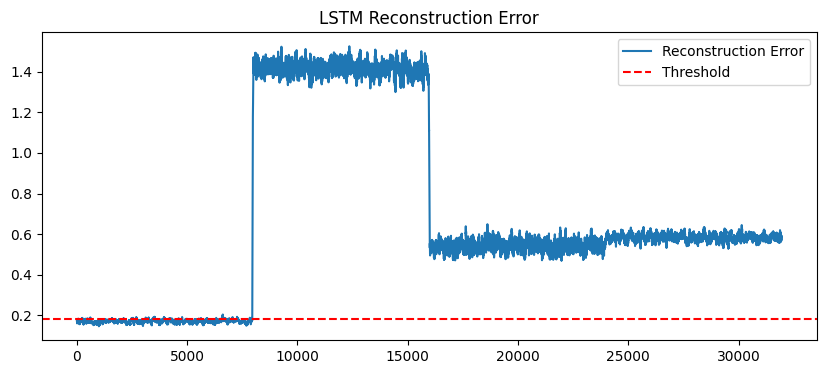

In [62]:
plt.figure(figsize=(10, 4))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('LSTM Reconstruction Error')
plt.show()

## Conclusion
This project implemented both classical and deep learning approaches for multivariate time-series anomaly detection.  
Isolation Forest provides a fast unsupervised baseline, while the LSTM Autoencoder captures temporal dependencies for improved anomaly detection.